In [1]:
import sqlite3
import pandas as pd


conn = sqlite3.connect('european_database.sqlite')

query = """
SELECT 
    m.*, d.name, d.country
FROM matchs m 
JOIN divisions d ON d.division == m.Div
"""

df = (
    pd.read_sql_query(query, conn)
    .assign(Date = lambda x: pd.to_datetime(x.Date))
)

In [2]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
0,B1,2020-08-08,Club Brugge,Charleroi,0.0,1.0,A,2021,Division 1A,Belgium
1,B1,2020-08-08,Antwerp,Mouscron,1.0,1.0,D,2021,Division 1A,Belgium
2,B1,2020-08-08,Standard,Cercle Brugge,1.0,0.0,H,2021,Division 1A,Belgium
3,B1,2020-08-09,St Truiden,Gent,2.0,1.0,H,2021,Division 1A,Belgium
4,B1,2020-08-09,Waregem,Genk,1.0,2.0,A,2021,Division 1A,Belgium


## Creating a new dataset

In [4]:
EPL = df.loc[df['Div']=='E0']
EPL.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
918,E0,2020-09-12,Fulham,Arsenal,0.0,3.0,A,2021,Premier League,England
919,E0,2020-09-12,Crystal Palace,Southampton,1.0,0.0,H,2021,Premier League,England
920,E0,2020-09-12,Liverpool,Leeds,4.0,3.0,H,2021,Premier League,England
921,E0,2020-09-12,West Ham,Newcastle,0.0,2.0,A,2021,Premier League,England
922,E0,2020-09-13,West Brom,Leicester,0.0,3.0,A,2021,Premier League,England


In [5]:
arsenal = EPL.loc[(EPL['HomeTeam']=='Arsenal') & (EPL['season']==2021)]
arsenal.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
929,E0,2020-09-19,Arsenal,West Ham,2.0,1.0,H,2021,Premier League,England
952,E0,2020-10-04,Arsenal,Sheffield United,2.0,1.0,H,2021,Premier League,England
973,E0,2020-10-25,Arsenal,Leicester,0.0,1.0,A,2021,Premier League,England
995,E0,2020-11-08,Arsenal,Aston Villa,0.0,3.0,A,2021,Premier League,England
1013,E0,2020-11-29,Arsenal,Wolves,1.0,2.0,A,2021,Premier League,England


In [6]:
arsenal.groupby('FTR').size()

FTR
A    7
D    4
H    8
dtype: int64

In [7]:
epl_teams = EPL.loc[(EPL['season']==2021)]
epl_teams

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,season,name,country
918,E0,2020-09-12,Fulham,Arsenal,0.0,3.0,A,2021,Premier League,England
919,E0,2020-09-12,Crystal Palace,Southampton,1.0,0.0,H,2021,Premier League,England
920,E0,2020-09-12,Liverpool,Leeds,4.0,3.0,H,2021,Premier League,England
921,E0,2020-09-12,West Ham,Newcastle,0.0,2.0,A,2021,Premier League,England
922,E0,2020-09-13,West Brom,Leicester,0.0,3.0,A,2021,Premier League,England
...,...,...,...,...,...,...,...,...,...,...
1293,E0,2021-05-23,Liverpool,Crystal Palace,2.0,0.0,H,2021,Premier League,England
1294,E0,2021-05-23,Man City,Everton,5.0,0.0,H,2021,Premier League,England
1295,E0,2021-05-23,Sheffield United,Burnley,1.0,0.0,H,2021,Premier League,England
1296,E0,2021-05-23,West Ham,Southampton,3.0,0.0,H,2021,Premier League,England


In [8]:
hometeam = epl_teams.groupby(['FTR','HomeTeam'])['HomeTeam'].size().to_frame('Home').reset_index()
hometeam.head()

,FTR,HomeTeam,Home
0,A,Arsenal,7
1,A,Aston Villa,8
2,A,Brighton,6
3,A,Burnley,9
4,A,Chelsea,4


In [9]:
hometeam['FTR'] = hometeam['FTR'].replace(['A','H'], ['L','W'])
hometeam_new = hometeam.groupby(['HomeTeam','FTR']).sum()
hometeam_new.head()

Home
HomeTeam    FTR      
Arsenal     D       4
            L       7
            W       8
Aston Villa D       4
            L       8

In [10]:
awayteam = epl_teams.groupby(['FTR','AwayTeam'])['AwayTeam'].size().to_frame('Away').reset_index()
awayteam.head()

,FTR,AwayTeam,Away
0,A,Arsenal,10
1,A,Aston Villa,9
2,A,Brighton,5
3,A,Burnley,6
4,A,Chelsea,10


In [11]:
awayteam['FTR'] = awayteam['FTR'].replace(['A','H'], ['W','L'])
awayteam_new = awayteam.groupby(['AwayTeam','FTR']).sum()
awayteam_new.head()

Away
AwayTeam    FTR      
Arsenal     D       3
            L       6
            W      10
Aston Villa D       3
            L       7

In [37]:
concatenated = pd.concat([hometeam_new, awayteam_new], axis=1).fillna(0)
concatenated.head()

Home  Away
            FTR            
Arsenal     D       4   3.0
            L       7   6.0
            W       8  10.0
Aston Villa D       4   3.0
            L       8   7.0

In [13]:
total = concatenated['Home'] + concatenated['Away']
concatenated['Total'] = total

In [14]:
concatenated.head()

Home  Away  Total
            FTR                   
Arsenal     D       4   3.0    7.0
            L       7   6.0   13.0
            W       8  10.0   18.0
Aston Villa D       4   3.0    7.0
            L       8   7.0   15.0

In [15]:
EPL_teams = concatenated.reset_index()
EPL_teams.head()

,level_0,FTR,Home,Away,Total
0,Arsenal,D,4,3.0,7.0
1,Arsenal,L,7,6.0,13.0
2,Arsenal,W,8,10.0,18.0
3,Aston Villa,D,4,3.0,7.0
4,Aston Villa,L,8,7.0,15.0


In [16]:
Draw = EPL_teams.loc[EPL_teams['FTR']=='D']
Draw.head()

,level_0,FTR,Home,Away,Total
0,Arsenal,D,4,3.0,7.0
3,Aston Villa,D,4,3.0,7.0
6,Brighton,D,9,5.0,14.0
9,Burnley,D,6,3.0,9.0
12,Chelsea,D,6,4.0,10.0


In [17]:
Lose = EPL_teams.loc[EPL_teams['FTR']=='L']
Lose.head()

,level_0,FTR,Home,Away,Total
1,Arsenal,L,7,6.0,13.0
4,Aston Villa,L,8,7.0,15.0
7,Brighton,L,6,9.0,15.0
10,Burnley,L,9,10.0,19.0
13,Chelsea,L,4,5.0,9.0


In [18]:
Win = EPL_teams.loc[EPL_teams['FTR']=='W']
Win.head()

,level_0,FTR,Home,Away,Total
2,Arsenal,W,8,10.0,18.0
5,Aston Villa,W,7,9.0,16.0
8,Brighton,W,4,5.0,9.0
11,Burnley,W,4,6.0,10.0
14,Chelsea,W,9,10.0,19.0


In [36]:
df1 = Win.merge(right=Draw, how='inner', left_on='level_0', right_on='level_0')
df1.head()

,level_0,FTR_x,Home_x,Away_x,Total_x,FTR_y,Home_y,Away_y,Total_y
0,Arsenal,W,8,10.0,18.0,D,4,3.0,7.0
1,Aston Villa,W,7,9.0,16.0,D,4,3.0,7.0
2,Brighton,W,4,5.0,9.0,D,9,5.0,14.0
3,Burnley,W,4,6.0,10.0,D,6,3.0,9.0
4,Chelsea,W,9,10.0,19.0,D,6,4.0,10.0


In [20]:
df2 = df1.merge(right=Lose, how='inner', left_on='level_0', right_on='level_0')
df2.head()

,level_0,FTR_x,Home_x,Away_x,Total_x,FTR_y,Home_y,Away_y,Total_y,FTR,Home,Away,Total
0,Arsenal,W,8,10.0,18.0,D,4,3.0,7.0,L,7,6.0,13.0
1,Aston Villa,W,7,9.0,16.0,D,4,3.0,7.0,L,8,7.0,15.0
2,Brighton,W,4,5.0,9.0,D,9,5.0,14.0,L,6,9.0,15.0
3,Burnley,W,4,6.0,10.0,D,6,3.0,9.0,L,9,10.0,19.0
4,Chelsea,W,9,10.0,19.0,D,6,4.0,10.0,L,4,5.0,9.0


In [21]:
df2.rename(columns={'level_0':'Team','Home_x': 'Home_Win','Away_x':'Away_Win','Total_x':'Total_Win','Home_y':'Home_Draw','Away_y':'Away_Draw','Total_y':'Total_Draw','Home':'Home_Lose','Away':'Away_Lose','Total':'Total_Lose'}, inplace=True)

In [22]:
df2.head()

,Team,FTR_x,Home_Win,Away_Win,Total_Win,FTR_y,Home_Draw,Away_Draw,Total_Draw,FTR,Home_Lose,Away_Lose,Total_Lose
0,Arsenal,W,8,10.0,18.0,D,4,3.0,7.0,L,7,6.0,13.0
1,Aston Villa,W,7,9.0,16.0,D,4,3.0,7.0,L,8,7.0,15.0
2,Brighton,W,4,5.0,9.0,D,9,5.0,14.0,L,6,9.0,15.0
3,Burnley,W,4,6.0,10.0,D,6,3.0,9.0,L,9,10.0,19.0
4,Chelsea,W,9,10.0,19.0,D,6,4.0,10.0,L,4,5.0,9.0


In [23]:
EPL_scores = df2.drop(['FTR_x','FTR_y','FTR'], axis=1)

In [24]:
EPL_scores.head()

,Team,Home_Win,Away_Win,Total_Win,Home_Draw,Away_Draw,Total_Draw,Home_Lose,Away_Lose,Total_Lose
0,Arsenal,8,10.0,18.0,4,3.0,7.0,7,6.0,13.0
1,Aston Villa,7,9.0,16.0,4,3.0,7.0,8,7.0,15.0
2,Brighton,4,5.0,9.0,9,5.0,14.0,6,9.0,15.0
3,Burnley,4,6.0,10.0,6,3.0,9.0,9,10.0,19.0
4,Chelsea,9,10.0,19.0,6,4.0,10.0,4,5.0,9.0


In [34]:
EPL_scores.to_csv('EPL_scores.csv')

## Win percentage for every clubs in EPL

In [48]:
EPL_scores['Win_%'] = round((EPL_scores.Total_Win)/38*100)
EPL_scores.head()

,Team,Home_Win,Away_Win,Total_Win,Home_Draw,Away_Draw,Total_Draw,Home_Lose,Away_Lose,Total_Lose,Win_%
0,Arsenal,8,10.0,18.0,4,3.0,7.0,7,6.0,13.0,47.0
1,Aston Villa,7,9.0,16.0,4,3.0,7.0,8,7.0,15.0,42.0
2,Brighton,4,5.0,9.0,9,5.0,14.0,6,9.0,15.0,24.0
3,Burnley,4,6.0,10.0,6,3.0,9.0,9,10.0,19.0,26.0
4,Chelsea,9,10.0,19.0,6,4.0,10.0,4,5.0,9.0,50.0


In [90]:
win_rate = EPL_scores.loc[:,['Team','Win_%']]
win_rate.head()

,Team,Win_%
0,Arsenal,47.0
1,Aston Villa,42.0
2,Brighton,24.0
3,Burnley,26.0
4,Chelsea,50.0


## Finding relationhip between Possession and Win Rate for Every Teams in EPL

In [83]:
win_rate.replace('Man City','Manchester City',inplace=True)
win_rate.replace('Man United','Manchester United',inplace=True)
win_rate.replace('Wolves','Wolverhampton Wanderers',inplace=True)
win_rate.replace('West Brom','West Bromwich Albion',inplace=True)
win_rate.replace('Newcastle','Newcastle United',inplace=True)

In [91]:
win_rate.head()

,Team,Win_%
0,Arsenal,47.0
1,Aston Villa,42.0
2,Brighton,24.0
3,Burnley,26.0
4,Chelsea,50.0


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import warnings

warnings.filterwarnings('ignore')

In [26]:
data = pd.read_csv('football teams/Football teams.csv')
data.head()

,Team,Tournament,Goals,Shots pg,yellow_cards,red_cards,Possession%,Pass%,AerialsWon,Rating
0,Manchester City,Premier League,83,15.8,46,2,60.8,89.4,12.8,7.01
1,Bayern Munich,Bundesliga,99,17.1,44,3,58.1,85.5,12.9,6.95
2,Paris Saint-Germain,Ligue 1,86,15.0,73,7,60.1,89.5,9.5,6.88
3,Barcelona,LaLiga,85,15.3,68,2,62.4,89.7,10.6,6.87
4,Real Madrid,LaLiga,67,14.4,57,2,57.7,87.7,11.8,6.86


In [86]:
EPL = data.loc[data.Tournament=='Premier League']
EPL.head()

,Team,Tournament,Goals,Shots pg,yellow_cards,red_cards,Possession%,Pass%,AerialsWon,Rating
0,Manchester City,Premier League,83,15.8,46,2,60.8,89.4,12.8,7.01
5,Manchester United,Premier League,73,13.8,64,1,54.5,84.8,14.5,6.85
7,Aston Villa,Premier League,55,13.7,63,4,49.1,78.6,19.4,6.84
11,Chelsea,Premier League,58,14.6,49,3,58.6,87.0,15.2,6.83
12,Liverpool,Premier League,68,16.0,40,0,59.0,85.7,14.3,6.82


In [88]:
pos_win = EPL.merge(right=win_rate, how='inner', left_on='Team', right_on='Team')
pos_win.head()

,Team,Tournament,Goals,Shots pg,yellow_cards,red_cards,Possession%,Pass%,AerialsWon,Rating,Win_%
0,Manchester City,Premier League,83,15.8,46,2,60.8,89.4,12.8,7.01,71.0
1,Manchester United,Premier League,73,13.8,64,1,54.5,84.8,14.5,6.85,55.0
2,Aston Villa,Premier League,55,13.7,63,4,49.1,78.6,19.4,6.84,42.0
3,Chelsea,Premier League,58,14.6,49,3,58.6,87.0,15.2,6.83,50.0
4,Liverpool,Premier League,68,16.0,40,0,59.0,85.7,14.3,6.82,53.0


Text(0.5, 1.0, 'Relation of Possesion Games and Wins Rate')

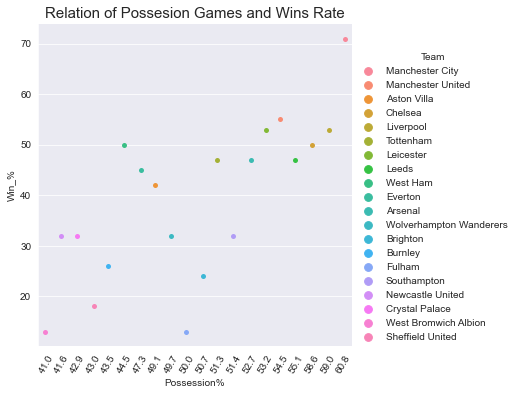

In [100]:
sns.catplot(data=pos_win, hue='Team',  y='Win_%', x='Possession%').set_xticklabels(rotation=60)
plt.title('Relation of Possesion Games and Wins Rate',fontsize = 15)

## Relationship between Pass Accuracy and Win Rate

Text(0.5, 1.0, 'Relation of Pass Accuracy and Win Rate')

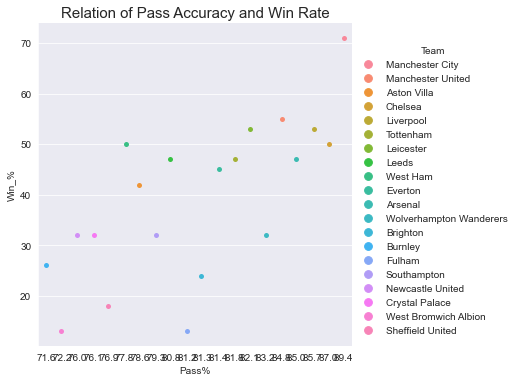

In [109]:
sns.catplot(x='Pass%', y='Win_%', data=pos_win , hue='Team')
plt.title('Relation of Pass Accuracy and Win Rate',fontsize = 15)

## Total goals of top 5 teams in EPL

In [29]:
top_epl = EPL.sort_values('Goals', ascending=False).head(5)
top_epl

,Team,Tournament,Goals,Shots pg,yellow_cards,red_cards,Possession%,Pass%,AerialsWon,Rating
0,Manchester City,Premier League,83,15.8,46,2,60.8,89.4,12.8,7.01
5,Manchester United,Premier League,73,13.8,64,1,54.5,84.8,14.5,6.85
12,Liverpool,Premier League,68,16.0,40,0,59.0,85.7,14.3,6.82
15,Tottenham,Premier League,68,11.7,53,2,51.3,81.8,16.4,6.81
17,Leicester,Premier League,68,12.8,61,0,53.2,82.1,16.2,6.80


Text(0.5, 0.98, 'Goals scored by top teams')

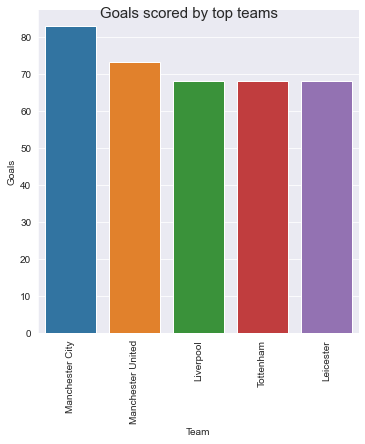

In [30]:
myFigure = sns.catplot(data=top_epl,x='Team',y='Goals',kind='bar').set_xticklabels(rotation=90)
myFigure.fig.suptitle("Goals scored by top teams", fontsize=15)

## Shots Percentage for Every Teams in EPL

Text(0.5, 0.98, 'Shots % for every teams')

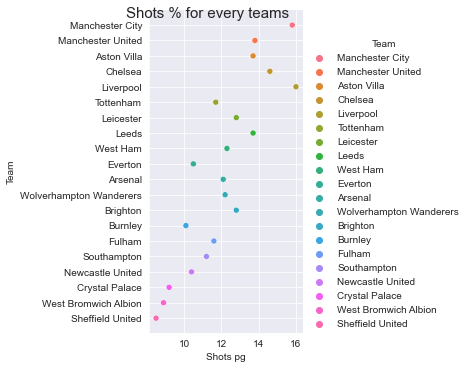

In [101]:
shot = sns.relplot(x='Shots pg', y='Team', data=EPL, hue='Team')
shot.fig.suptitle("Shots % for every teams", fontsize=15)
# sns.set(font_scale=1)

## Comparison of 5 Different Leagues

Text(0.5, 1.0, ' The different league details')

<Figure size 720x720 with 0 Axes>

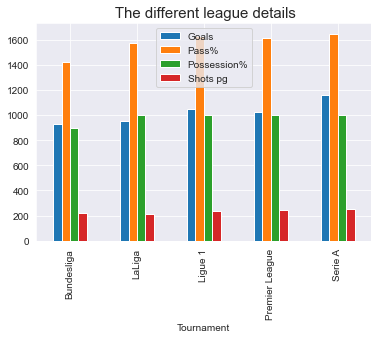

In [102]:
plt.figure(figsize=(10,10))
tournaments=data.groupby('Tournament')['Goals','Pass%','Possession%','Shots pg'].sum().plot(kind='bar')
plt.title(" The different league details", fontsize=15)

Text(0.5, 1.0, 'Tournament and Pass % in them')

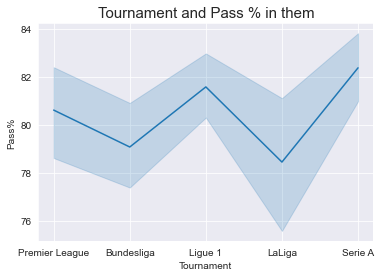

In [111]:
sns.lineplot(x='Tournament',y='Pass%',data=data)
plt.title("Tournament and Pass % in them", fontsize=15)